<a href="https://colab.research.google.com/github/huseinsm/IS-Kelompok-3/blob/main/Hatespeech_Husein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
from google.colab import files
trainCSV = files.upload()

df_hatespeech = pd.read_csv('hatespeech.csv', encoding='latin1')

## CLEANING & PREPROCESSING

In [ ]:
df_hatespeech.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
df_hatespeech = df_hatespeech[['Tweet', 'HS']]
display(df_hatespeech.head())

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1


In [ ]:
df_hatespeech.dropna(subset=['Tweet'], inplace=True)
df_hatespeech['Tweet'] = df_hatespeech['Tweet'].str.strip()
df_hatespeech = df_hatespeech[df_hatespeech['Tweet'] != '']

## EDA

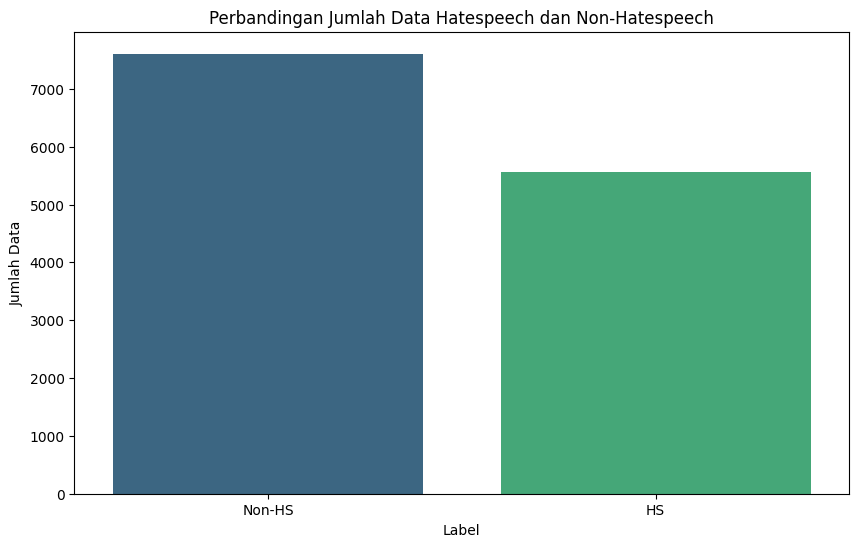

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_hatespeech, x='HS', palette='viridis')
plt.title('Perbandingan Jumlah Data Hatespeech dan Non-Hatespeech')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks([0, 1], ['Non-HS', 'HS'])
plt.show()

In [ ]:
# Rata-rata panjang teks per data
df_hatespeech["tweet_length"] = df_hatespeech["Tweet"].apply(lambda x: len(str(x).split()))
print("\nRata-rata panjang teks (dalam kata):", round(df_hatespeech["tweet_length"].mean(), 2))


Rata-rata panjang teks (dalam kata): 17.28


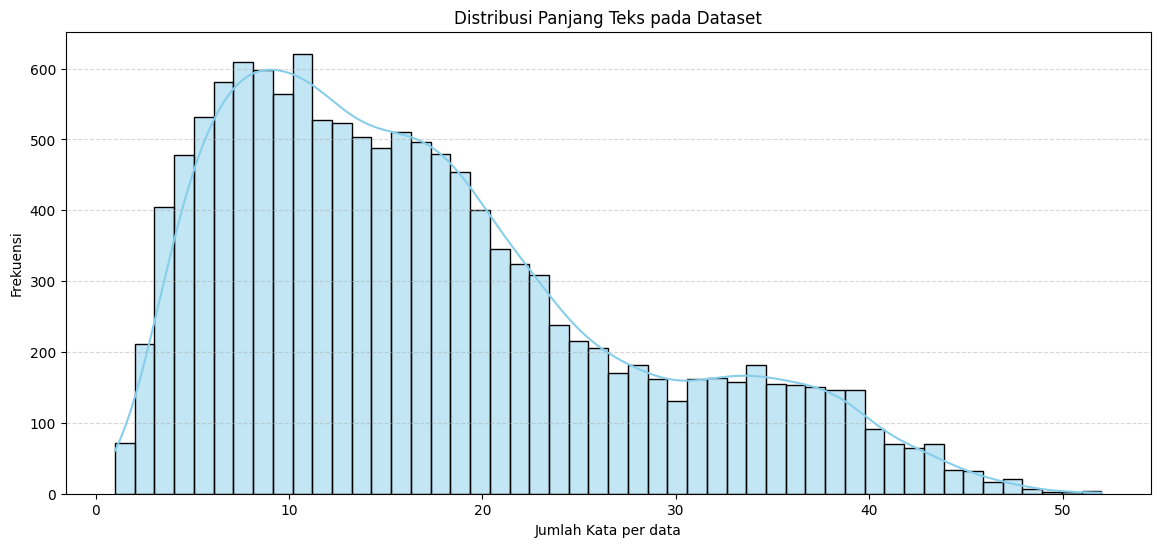

In [ ]:
# Distribusi panjang teks email
import seaborn as sns

plt.figure(figsize=(14,6))
sns.histplot(df_hatespeech["tweet_length"], bins=50, kde=True, color='skyblue')
plt.title("Distribusi Panjang Teks pada Dataset")
plt.xlabel("Jumlah Kata per data")
plt.ylabel("Frekuensi")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
df_hatespeech.to_csv('df_hatespeech_cleaned_little.csv', index=False)

In [ ]:
from google.colab import files
trainCSV = files.upload()

df_hatespeech = pd.read_csv('df_hatespeech_cleaned_little.csv', encoding='latin1')

Saving df_hatespeech_cleaned_little.csv to df_hatespeech_cleaned_little.csv


## MODELLING

# 1. IndoBERT

In [ ]:
# AutoModelForSequenceClassification

In [ ]:
!pip install -q transformers datasets evaluate scikit-learn

from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset, DatasetDict
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
df = df_hatespeech[['Tweet','HS']].dropna().rename(columns={'Tweet':'text','HS':'label'})
df['label'] = df['label'].astype(int)

# Xplit train/valid/test (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(valid_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

max_len = 256
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )

tokenized = ds.map(tokenize_fn, batched=True, remove_columns=['text'])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch")

Map:   0%|          | 0/9876 [00:00<?, ? examples/s]

Map:   0%|          | 0/1646 [00:00<?, ? examples/s]

Map:   0%|          | 0/1647 [00:00<?, ? examples/s]

In [ ]:
# Metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

In [ ]:
# Model & tokenizer IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [ ]:
# model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training args
args = TrainingArguments(
    output_dir="./indobert-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

# Evaluasi valid & test
print("== Valid ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.279000,0.292748,0.871203,0.824161,0.883453,0.852778
2,0.157100,0.284253,0.893682,0.896341,0.846043,0.870466
3,0.078400,0.371614,0.892467,0.871060,0.874820,0.872936


== Valid ==


{'eval_loss': 0.3716141879558563, 'eval_accuracy': 0.8924665856622114, 'eval_precision': 0.8710601719197708, 'eval_recall': 0.874820143884892, 'eval_f1': 0.8729361091170137, 'eval_runtime': 5.7143, 'eval_samples_per_second': 288.047, 'eval_steps_per_second': 18.025, 'epoch': 3.0}
== Test ==
{'eval_loss': 0.39015865325927734, 'eval_accuracy': 0.9016393442622951, 'eval_precision': 0.8858381502890174, 'eval_recall': 0.8807471264367817, 'eval_f1': 0.8832853025936599, 'eval_runtime': 5.7955, 'eval_samples_per_second': 284.185, 'eval_steps_per_second': 17.772, 'epoch': 3.0}


<Figure size 500x500 with 0 Axes>

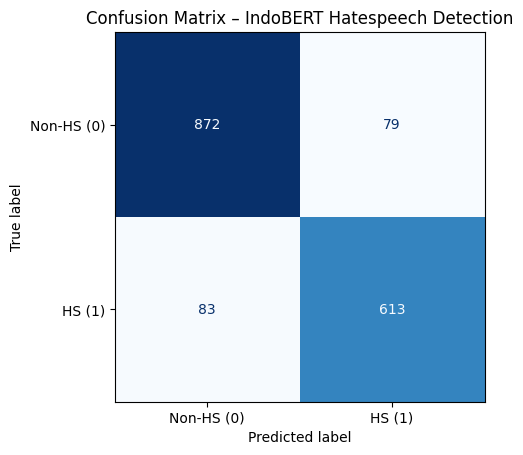

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hatespeech Detection")
plt.show()

In [ ]:
trainer.save_model("./indobert-hs-nonfreeze")

In [ ]:
# AutoModel -> freeze layer 1 - 7

In [ ]:
!pip install -q transformers datasets scikit-learn evaluate torch

In [ ]:
# freeze layer 1–7
class IndoBERT_HoaxClassifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_p=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        for name, param in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

model = IndoBERT_HoaxClassifier(MODEL_NAME)

# Training arguments
args = TrainingArguments(
    output_dir="./indobert-freeze",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Evaluasi
print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.398900,0.334014,0.860267,0.793190,0.905036,0.845430
2,0.257800,0.329224,0.888214,0.867626,0.867626,0.867626
3,0.193700,0.360728,0.891252,0.869628,0.873381,0.871500


== Validation ==


{'eval_loss': 0.3607279658317566, 'eval_accuracy': 0.8912515188335358, 'eval_precision': 0.8696275071633238, 'eval_recall': 0.8733812949640288, 'eval_f1': 0.8715003589375449, 'eval_runtime': 6.365, 'eval_samples_per_second': 258.6, 'eval_steps_per_second': 32.364, 'epoch': 3.0}
== Test ==
{'eval_loss': 0.36949622631073, 'eval_accuracy': 0.8809957498482088, 'eval_precision': 0.8581661891117478, 'eval_recall': 0.860632183908046, 'eval_f1': 0.8593974175035868, 'eval_runtime': 6.6485, 'eval_samples_per_second': 247.724, 'eval_steps_per_second': 30.984, 'epoch': 3.0}


<Figure size 500x500 with 0 Axes>

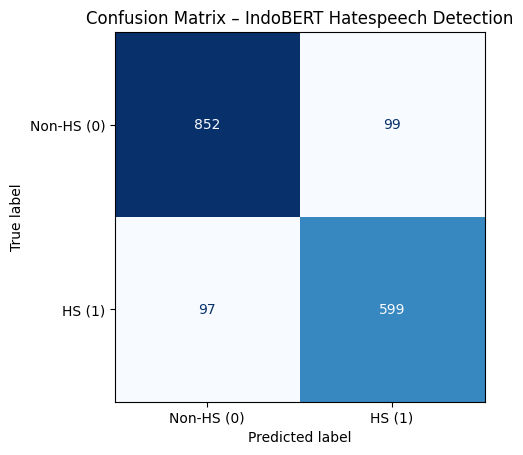

In [ ]:
# --- Confusion Matrix ---
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hatespeech Detection")
plt.show()

In [ ]:
trainer.save_model("./indobert-hs-freeze")

## 2. Indo BERTTweet

In [ ]:
# AutoModelForSequenceClassification

In [ ]:
MODEL_NAME = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

args = TrainingArguments(
    output_dir="./indobertweet-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489600,0.483134,0.772783,0.698885,0.811511,0.750999
2,0.392300,0.447298,0.808019,0.846435,0.666187,0.745572
3,0.263100,0.437543,0.823815,0.839196,0.720863,0.775542


== Validation ==


{'eval_loss': 0.4375426173210144, 'eval_accuracy': 0.8238153098420413, 'eval_precision': 0.8391959798994975, 'eval_recall': 0.720863309352518, 'eval_f1': 0.7755417956656346, 'eval_runtime': 6.4624, 'eval_samples_per_second': 254.706, 'eval_steps_per_second': 31.877, 'epoch': 3.0}
== Test ==
{'eval_loss': 0.4352753758430481, 'eval_accuracy': 0.8233151183970856, 'eval_precision': 0.8282009724473258, 'eval_recall': 0.7341954022988506, 'eval_f1': 0.7783701447067783, 'eval_runtime': 6.5001, 'eval_samples_per_second': 253.383, 'eval_steps_per_second': 31.692, 'epoch': 3.0}


<Figure size 500x500 with 0 Axes>

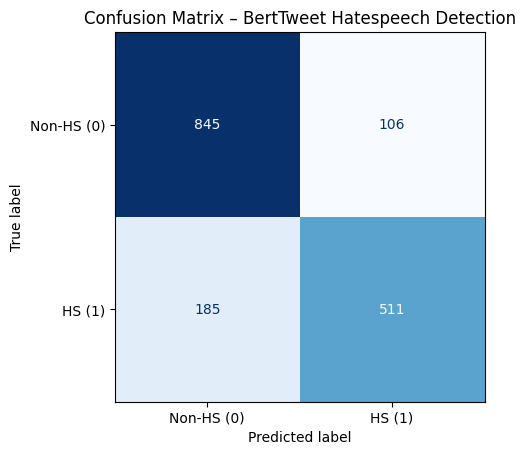

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BertTweet Hatespeech Detection")
plt.show()

In [ ]:
trainer.save_model("./berttweet-hs-nonfreeze")

In [ ]:
# AutoModel -> freeze 7 layer

In [ ]:
MODEL = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

class IndoBERTweetHoaxCls(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        # freeze 7
        for name, p in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                p.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(cls))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

model = IndoBERTweetHoaxCls(MODEL)

# Metrics
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"]}

# sederhana
args = TrainingArguments(
    output_dir="./indobertweet-freeze7",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))
print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644400,0.547152,0.715067,0.652335
2,0.539500,0.512984,0.756987,0.686028
3,0.471600,0.503978,0.774605,0.717010


== Validation ==


{'eval_loss': 0.5039781928062439, 'eval_accuracy': 0.7746051032806804, 'eval_f1': 0.7170099160945843, 'eval_runtime': 6.1709, 'eval_samples_per_second': 266.734, 'eval_steps_per_second': 33.382, 'epoch': 3.0}
== Test ==
{'eval_loss': 0.4796352684497833, 'eval_accuracy': 0.7735276259866424, 'eval_f1': 0.7146136189747513, 'eval_runtime': 6.4455, 'eval_samples_per_second': 255.529, 'eval_steps_per_second': 31.96, 'epoch': 3.0}


<Figure size 500x500 with 0 Axes>

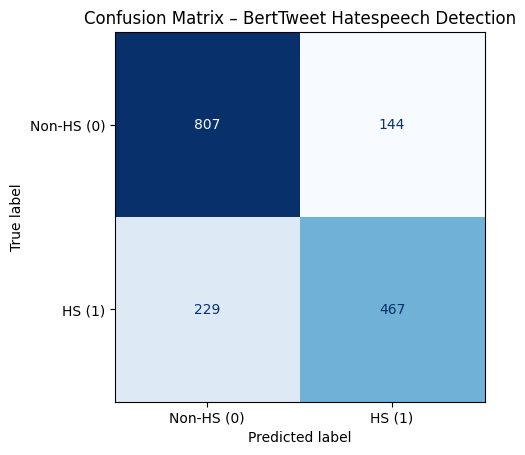

In [ ]:
# --- Confusion Matrix ---
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BertTweet Hatespeech Detection")
plt.show()

## 3. BERTTweet Hatespeech

In [ ]:
MODEL_NAME = "Exqrch/IndoBERTweet-HateSpeech"
tokenizer = "indolem/indobertweet-base-uncased"

In [ ]:
MODEL_NAME = "Exqrch/IndoBERTweet-HateSpeech"
tokenizer_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)

# model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training args
args = TrainingArguments(
    output_dir="./indobert-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.546300,0.536365,0.735115,0.771488,0.529496,0.627986
2,0.416600,0.480474,0.782503,0.819734,0.621583,0.707038
3,0.389700,0.468564,0.791009,0.802065,0.670504,0.730408


== Validation ==


{'eval_loss': 0.46856430172920227, 'eval_accuracy': 0.7910085054678008, 'eval_precision': 0.802065404475043, 'eval_recall': 0.6705035971223021, 'eval_f1': 0.7304075235109718, 'eval_runtime': 5.6877, 'eval_samples_per_second': 289.398, 'eval_steps_per_second': 18.109, 'epoch': 3.0}
== Test ==
{'eval_loss': 0.45609915256500244, 'eval_accuracy': 0.7959927140255009, 'eval_precision': 0.8082191780821918, 'eval_recall': 0.6781609195402298, 'eval_f1': 0.7375, 'eval_runtime': 5.7797, 'eval_samples_per_second': 284.962, 'eval_steps_per_second': 17.821, 'epoch': 3.0}


<Figure size 500x500 with 0 Axes>

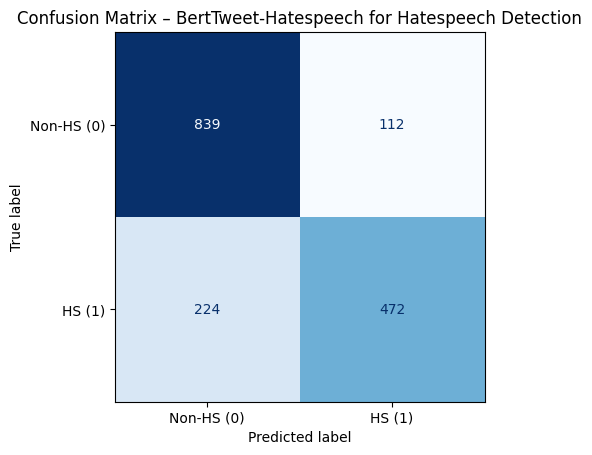

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BertTweet-Hatespeech for Hatespeech Detection")
plt.show()

EKSPERIMEN

In [ ]:
# Bersihkan teks

## IndoBERT

In [ ]:
# clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Hapus tag di awal seperti [HOAX], (SALAH), dll
    text = re.sub(r'^[\[\(]\s*[^)\]]+\s*[\)\]]', '', text)
    # Hapus link
    text = re.sub(r'http\S+|www\S+', '', text)
    # Hapus karakter selain huruf dan spasi
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Hilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df_hatespeech.head()

,Tweet,HS,tweet_length
0,- disaat semua cowok berusaha melacak perhatia...,1,25
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,21
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,37
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,14
4,USER USER Kaum cebong kapir udah keliatan dong...,1,14


In [ ]:
# df_hatespeech['Tweet'] = df_hatespeech['Tweet'].apply(clean_text)

In [ ]:
# df_hatespeech.head()

,Tweet,HS,tweet_length
0,disaat semua cowok berusaha melacak perhatian ...,1,25
1,rt user user siapa yang telat ngasih tau elu e...,0,21
2,kadang aku berfikir kenapa aku tetap percaya p...,0,37
3,user user aku itu aku n nku tau matamu sipit t...,0,14
4,user user kaum cebong kapir udah keliatan dong...,1,14


In [ ]:
# df_hatespeech.to_csv('df_hatespeech_cleaned_full.csv', index=False)

In [ ]:
!pip install -q transformers datasets evaluate scikit-learn

from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset, DatasetDict
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
df = df_hatespeech[['Tweet','HS']].dropna().rename(columns={'Tweet':'text','HS':'label'})
df['label'] = df['label'].astype(int)

# Xplit train/valid/test (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(valid_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/9876 [00:00<?, ? examples/s]

Map:   0%|          | 0/1646 [00:00<?, ? examples/s]

Map:   0%|          | 0/1647 [00:00<?, ? examples/s]

In [ ]:
# Model & tokenizer IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

max_len = 256
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )

tokenized = ds.map(tokenize_fn, batched=True, remove_columns=['text'])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch")

In [ ]:
# Metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

In [ ]:
# model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training args
args = TrainingArguments(
    output_dir="./indobert-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
trainer.train()

# Evaluasi valid & test
print("== Valid ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.282800,0.322647,0.855407,0.780368,0.915108,0.842384
2,0.169200,0.285344,0.889429,0.880000,0.854676,0.867153
3,0.108600,0.417703,0.890036,0.874636,0.863309,0.868936
4,0.059200,0.492800,0.888214,0.865522,0.870504,0.868006
5,0.022900,0.591020,0.894289,0.871612,0.879137,0.875358
6,0.030000,0.690594,0.889429,0.907790,0.821583,0.862538
7,0.015400,0.690315,0.891859,0.861538,0.886331,0.873759
8,0.012100,0.688425,0.891859,0.889894,0.848921,0.868925
9,0.007800,0.725293,0.891252,0.881657,0.857554,0.869438
10,0.003200,0.728876,0.892467,0.882006,0.860432,0.871085


== Valid ==


{'eval_loss': 0.5910199284553528, 'eval_accuracy': 0.8942891859052248, 'eval_precision': 0.8716119828815977, 'eval_recall': 0.879136690647482, 'eval_f1': 0.8753581661891118, 'eval_runtime': 6.2387, 'eval_samples_per_second': 263.835, 'eval_steps_per_second': 16.51, 'epoch': 10.0}
== Test ==
{'eval_loss': 0.6375857591629028, 'eval_accuracy': 0.8846387370977535, 'eval_precision': 0.8614285714285714, 'eval_recall': 0.8663793103448276, 'eval_f1': 0.8638968481375359, 'eval_runtime': 6.3436, 'eval_samples_per_second': 259.63, 'eval_steps_per_second': 16.237, 'epoch': 10.0}


<Figure size 500x500 with 0 Axes>

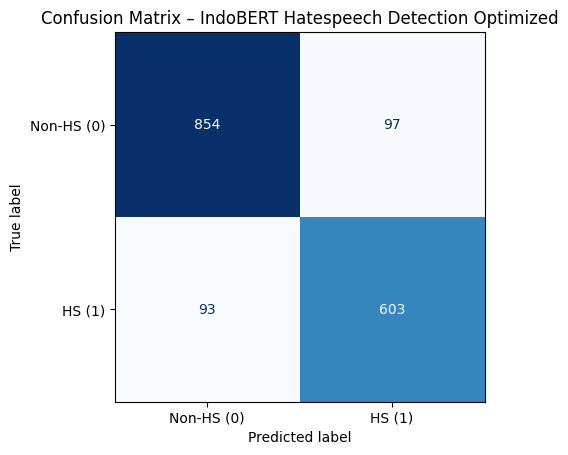

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hatespeech Detection Optimized")
plt.show()

In [ ]:
trainer.save_model("./indobert-hs-nonfreeze-optimized")

In [ ]:
# AutoModel -> freeze layer 1 - 7

In [ ]:
!pip install -q transformers datasets scikit-learn evaluate torch

In [ ]:
# Model & tokenizer IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

max_len = 256
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )

tokenized = ds.map(tokenize_fn, batched=True, remove_columns=['text'])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch")

Map:   0%|          | 0/9876 [00:00<?, ? examples/s]

Map:   0%|          | 0/1646 [00:00<?, ? examples/s]

Map:   0%|          | 0/1647 [00:00<?, ? examples/s]

In [ ]:
# freeze layer 1–7
class IndoBERT_HoaxClassifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_p=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        for name, param in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

model = IndoBERT_HoaxClassifier(MODEL_NAME)

# Training arguments
args = TrainingArguments(
    output_dir="./indobert-freeze",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Evaluasi
print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.384518,0.836574,0.745958,0.929496,0.827675
2,0.344900,0.313528,0.875456,0.838398,0.873381,0.855532
3,0.344900,0.327771,0.888821,0.868876,0.867626,0.868251
4,0.180800,0.347726,0.894289,0.888227,0.857554,0.872621
5,0.104400,0.465609,0.881531,0.850140,0.873381,0.861604
6,0.104400,0.588824,0.893074,0.897397,0.843165,0.869436
7,0.054700,0.685411,0.886391,0.875740,0.851799,0.863603
8,0.054700,0.731134,0.886999,0.864092,0.869065,0.866571
9,0.032000,0.809435,0.887606,0.875000,0.856115,0.865455
10,0.019000,0.814545,0.885784,0.865801,0.863309,0.864553


== Validation ==


{'eval_loss': 0.34772562980651855, 'eval_accuracy': 0.8942891859052248, 'eval_precision': 0.8882265275707899, 'eval_recall': 0.8575539568345324, 'eval_f1': 0.8726207906295754, 'eval_runtime': 6.3565, 'eval_samples_per_second': 258.946, 'eval_steps_per_second': 16.204, 'epoch': 10.0}
== Test ==
{'eval_loss': 0.37728920578956604, 'eval_accuracy': 0.8828172434729812, 'eval_precision': 0.8781954887218045, 'eval_recall': 0.8390804597701149, 'eval_f1': 0.858192505510654, 'eval_runtime': 6.3732, 'eval_samples_per_second': 258.425, 'eval_steps_per_second': 16.161, 'epoch': 10.0}


<Figure size 500x500 with 0 Axes>

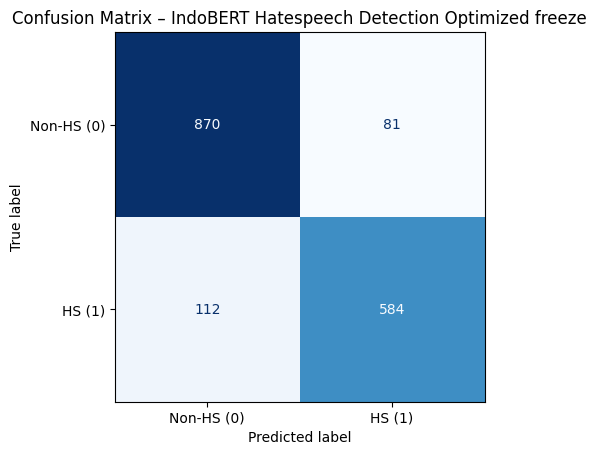

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hatespeech Detection Optimized freeze")
plt.show()

In [ ]:
trainer.save_model("./indobert-hs--optimized-freeze")

## BERTTweet

In [ ]:
MODEL_NAME = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

args = TrainingArguments(
    output_dir="./indobertweet-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.511700,0.485327,0.767315,0.798851,0.600000,0.685292
2,0.389900,0.438181,0.813487,0.851449,0.676259,0.753809
3,0.333200,0.416159,0.829283,0.800872,0.792806,0.796819
4,0.259900,0.461441,0.835966,0.841091,0.753957,0.795144
5,0.198100,0.442006,0.840826,0.809728,0.814388,0.812052
6,0.152700,0.489225,0.845079,0.840557,0.781295,0.809843
7,0.139200,0.578360,0.845079,0.821637,0.808633,0.815083
8,0.074600,0.672809,0.832321,0.788171,0.824460,0.805907
9,0.093800,0.723074,0.845079,0.858306,0.758273,0.805195
10,0.051400,0.731108,0.842041,0.833078,0.782734,0.807122


== Validation ==


{'eval_loss': 0.5783596634864807, 'eval_accuracy': 0.8450789793438639, 'eval_precision': 0.8216374269005848, 'eval_recall': 0.8086330935251799, 'eval_f1': 0.8150833937635968, 'eval_runtime': 6.229, 'eval_samples_per_second': 264.25, 'eval_steps_per_second': 16.536, 'epoch': 10.0}
== Test ==
{'eval_loss': 0.5551703572273254, 'eval_accuracy': 0.8482088646023073, 'eval_precision': 0.8204022988505747, 'eval_recall': 0.8204022988505747, 'eval_f1': 0.8204022988505747, 'eval_runtime': 6.3623, 'eval_samples_per_second': 258.869, 'eval_steps_per_second': 16.189, 'epoch': 10.0}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.641800,0.543154,0.721750,0.684867,0.631655,0.657186
2,0.536200,0.518571,0.755164,0.760714,0.612950,0.678884
3,0.470000,0.503932,0.766707,0.750403,0.670504,0.708207


<Figure size 500x500 with 0 Axes>

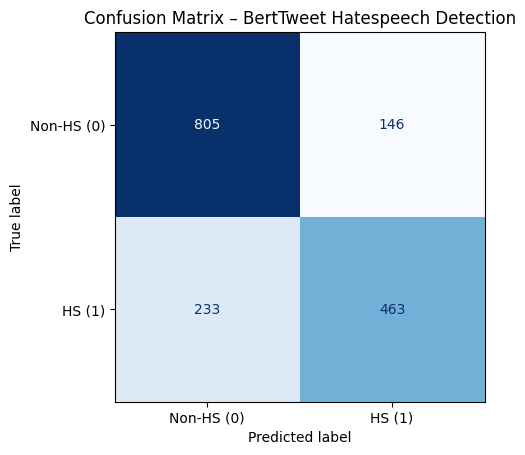

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-HS (0)", "HS (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BertTweet Hatespeech Detection")
plt.show()

In [ ]:
trainer.save_model("./berttweet-hs-nonfreeze-optimized")